In [1]:
# Make sure to install the requirements with pip install -r requirements.txt
import os
os.chdir('..')
from matplotlib import pyplot as plt
import numpy as np
import torch
from lib.model import get_model_and_optim
from lib.data import prepare_nuclear_data
from lib.utils import  PlottingContext, IO, get_rms
from sklearn.decomposition import PCA
import seaborn as sns
sns.set_style('white')
sns.set_context('paper')
import glob
from collections import defaultdict

In [90]:
import re
# locations = glob.glob('/checkpoint/nolte/nuclr/long-runs/*')
locations = glob.glob('/checkpoint/nolte/NuCLR-MechInterp-results/*')
print(locations)
# get train fracs for full
# all_re = re.compile(".*/epochs-50000-binding100\+.*-seed(\d)-dataseed\d-trainfrac(\d+\.\d+).*ge8")
all_re = re.compile("epochs-100000-binding100\+.*-seed(\d)-dataseed\d-trainfrac(\d+\.\d+)-nuclei_ge8-hiddendim1024-LR0.0003")
binding_re = re.compile(".*/long_run-binding100-seed0-trainfrac(\d+\.\d+)")
binding_semf_re = re.compile(".*/long_run-binding_semf100-seed0-trainfrac(\d+\.\d+)")
all_re_200k = re.compile("epochs-200000-binding100\+.*-seed(\d)-dataseed\d-trainfrac(\d+\.\d+)-nuclei_ge8-hiddendim1024-LR0.0003-modelbaseline")
# get train fracs for partial
all_trainfracs = {}
for loc in locations:
    match = all_re_200k.search(loc)
    if match is not None:
      if float(match.group(2)) == 1.0: continue
      # if float(match.group(2)) == 0.1: continue
      all_trainfracs[(int(match.group(1)), float(match.group(2)))] = loc
all_trainfracs

['/checkpoint/nolte/NuCLR-MechInterp-results/long_run-binding_semf100-seed0', '/checkpoint/nolte/NuCLR-MechInterp-results/long_run-binding100-seed0', '/checkpoint/nolte/NuCLR-MechInterp-results/long_run-z1-seed0', '/checkpoint/nolte/NuCLR-MechInterp-results/long_run-n1-seed0', '/checkpoint/nolte/NuCLR-MechInterp-results/long_run-radius0.02-seed0', '/checkpoint/nolte/NuCLR-MechInterp-results/long_run-qa200-seed0', '/checkpoint/nolte/NuCLR-MechInterp-results/long_run-qbm200-seed0', '/checkpoint/nolte/NuCLR-MechInterp-results/long_run-qbm_n200-seed0', '/checkpoint/nolte/NuCLR-MechInterp-results/long_run-qec200-seed0', '/checkpoint/nolte/NuCLR-MechInterp-results/long_run-sn200-seed0', '/checkpoint/nolte/NuCLR-MechInterp-results/long_run-sp200-seed0', '/checkpoint/nolte/NuCLR-MechInterp-results/long_run-binding100+z1+n1+radius0.02+qa200+qbm200+qbm_n200+qec200+sn200+sp200-seed0', '/checkpoint/nolte/NuCLR-MechInterp-results/trainfrac_0.8', '/checkpoint/nolte/NuCLR-MechInterp-results/trainfrac

{(0,
  0.1): '/checkpoint/nolte/NuCLR-MechInterp-results/epochs-200000-binding100+z1+n1+radius0.02+qa200+qbm200+qbm_n200+qec200+sn200+sp200-seed0-dataseed0-trainfrac0.1-nuclei_ge8-hiddendim1024-LR0.0003-modelbaseline',
 (1,
  0.1): '/checkpoint/nolte/NuCLR-MechInterp-results/epochs-200000-binding100+z1+n1+radius0.02+qa200+qbm200+qbm_n200+qec200+sn200+sp200-seed1-dataseed1-trainfrac0.1-nuclei_ge8-hiddendim1024-LR0.0003-modelbaseline',
 (2,
  0.1): '/checkpoint/nolte/NuCLR-MechInterp-results/epochs-200000-binding100+z1+n1+radius0.02+qa200+qbm200+qbm_n200+qec200+sn200+sp200-seed2-dataseed2-trainfrac0.1-nuclei_ge8-hiddendim1024-LR0.0003-modelbaseline',
 (0,
  0.2): '/checkpoint/nolte/NuCLR-MechInterp-results/epochs-200000-binding100+z1+n1+radius0.02+qa200+qbm200+qbm_n200+qec200+sn200+sp200-seed0-dataseed0-trainfrac0.2-nuclei_ge8-hiddendim1024-LR0.0003-modelbaseline',
 (1,
  0.2): '/checkpoint/nolte/NuCLR-MechInterp-results/epochs-200000-binding100+z1+n1+radius0.02+qa200+qbm200+qbm_n200+qec

In [135]:
def get_all_checkpoints_from(dir):
    checkpoints = {}
    for ckpt in os.listdir(dir):
        if ckpt.endswith('.pt') and "-" in ckpt:
            epoch = int(ckpt.split('-')[1].split('.')[0])
            if epoch % 5000 == 0: # WARNING
                checkpoints[epoch] = ckpt
    return checkpoints

def get_preds(X, model, batch=10000):
    preds = torch.zeros(X.shape[0], 1).to(X.device)
    with torch.no_grad():
        for i in range(0, X.shape[0], batch):
            preds_ = model(X[i:i+batch])
            # preds_ = torch.gather(preds_, 1, X[i:i+batch, [2]])
            preds[i:i+batch] = preds_
    return preds

def mask_elements_used_in_train(data):
    non_nan_targets = ~torch.isnan(data.y.view(-1))
    X_train = data.X[data.train_mask & non_nan_targets]
    Z_train = X_train[:, 0].unique() 
    N_train = X_train[:, 1].unique()
    return torch.isin(data.X[:, 0], Z_train) & torch.isin(data.X[:, 1], N_train)

def get_rms(model, data, split="all"):
    #filter out nans
    non_nan_targets = ~torch.isnan(data.y.view(-1))

    if split == "all":
        mask = torch.ones_like(data.y.view(-1), dtype=torch.bool)
    elif split == "train":
        mask = data.train_mask
    elif split == "val":
        mask = data.val_mask & mask_elements_used_in_train(data)
        print(mask.float().mean().item(), end="\r")

    X = data.X[non_nan_targets & mask]
    y = data.y[non_nan_targets & mask]
    

    preds = get_preds(X, model)
    rms = {}
    for i, task_name in enumerate(data.output_map):
        task_mask = X[:, 2] == i
        rms[task_name] = torch.sqrt(torch.mean((preds[task_mask] - y[task_mask])**2)).item()
    return rms

In [136]:
perfs = {}
import tqdm
for frac, location in tqdm.tqdm(all_trainfracs.items()):
  args = IO.load_args(f"{location}/args.yaml")
  args.DEV = "cuda:1"
  data = prepare_nuclear_data(args)
  model = get_model_and_optim(data, args)[0]
  model.load_state_dict(torch.load(f"{location}/ckpts/model.pt"))

  checkpoints = get_all_checkpoints_from(location + '/ckpts')

  print(frac)
  task_rms_values = {}
  for epoch, ckpt in checkpoints.items():
      model.load_state_dict(torch.load(f"{location}/ckpts/{ckpt}"))
      task_rms_values[epoch] = get_rms(model, data, "val")["binding"]
  perfs[frac] = task_rms_values


  0%|          | 0/27 [00:00<?, ?it/s]

(0, 0.1)


  4%|▎         | 1/27 [00:01<00:39,  1.50s/it]

(1, 0.1)9823226929


  7%|▋         | 2/27 [00:02<00:33,  1.34s/it]

(2, 0.1)061504364


 11%|█         | 3/27 [00:03<00:30,  1.28s/it]

(0, 0.2)0407600403


 15%|█▍        | 4/27 [00:05<00:28,  1.24s/it]

(1, 0.2)5815925598


 19%|█▊        | 5/27 [00:06<00:26,  1.21s/it]

(2, 0.2)658290863


 22%|██▏       | 6/27 [00:07<00:26,  1.28s/it]

(0, 0.3)6229362488


 26%|██▌       | 7/27 [00:08<00:24,  1.24s/it]

(1, 0.3)3795471191


 30%|██▉       | 8/27 [00:09<00:22,  1.21s/it]

(2, 0.3)


 33%|███▎      | 9/27 [00:11<00:21,  1.18s/it]

(0, 0.4)


 37%|███▋      | 10/27 [00:12<00:21,  1.24s/it]

(1, 0.4)2506942749


 41%|████      | 11/27 [00:13<00:19,  1.20s/it]

(2, 0.4)0083274841


 44%|████▍     | 12/27 [00:14<00:17,  1.16s/it]

(0, 0.5)9474067688


 48%|████▊     | 13/27 [00:15<00:15,  1.12s/it]

(1, 0.5)16566848755


 52%|█████▏    | 14/27 [00:16<00:14,  1.11s/it]

(2, 0.5)3355731964


 56%|█████▌    | 15/27 [00:18<00:15,  1.25s/it]

(0, 0.6)1145362854


 59%|█████▉    | 16/27 [00:19<00:13,  1.25s/it]

(1, 0.6)849817276


 63%|██████▎   | 17/27 [00:20<00:12,  1.25s/it]

(2, 0.6)5422935486


 67%|██████▋   | 18/27 [00:22<00:11,  1.25s/it]

(0, 0.7)2718772888


 70%|███████   | 19/27 [00:23<00:10,  1.30s/it]

(1, 0.7)0565376282


 74%|███████▍  | 20/27 [00:24<00:09,  1.29s/it]

(2, 0.7)50416374207


 78%|███████▊  | 21/27 [00:25<00:07,  1.27s/it]

(0, 0.8)44324302673


 81%|████████▏ | 22/27 [00:27<00:06,  1.24s/it]

(1, 0.8)56011676788


 85%|████████▌ | 23/27 [00:28<00:05,  1.29s/it]

(2, 0.8)61124897003


 89%|████████▉ | 24/27 [00:29<00:03,  1.26s/it]

(0, 0.9)67552947998


 93%|█████████▎| 25/27 [00:30<00:02,  1.22s/it]

(1, 0.9)07436084747


 96%|█████████▋| 26/27 [00:32<00:01,  1.20s/it]

(2, 0.9)30518627167


100%|██████████| 27/27 [00:33<00:00,  1.23s/it]

In [137]:
last_epoch = list(checkpoints.keys())[-1]
print(last_epoch)

180000


In [138]:
# with RMS calculated only on the good elements, this is not valid anymore
def train_mask_has_all_elements(data):
  all_Z = data.X[:,0].unique()
  all_N = data.X[:,1].unique()
  train_X = data.X[data.train_mask]
  train_Z = train_X[:,0].unique()
  train_N = train_X[:,1].unique()
  for z in all_Z:
    if z not in train_Z:
      return False 
  for n in all_N:
    if n not in train_N:
      return False
  return True

keys = all_trainfracs.keys()
for key in keys:
  # model.load_state_dict(torch.load(f"{all_trainfracs[key]}/ckpts/model.pt"))
  args = IO.load_args(f"{all_trainfracs[key]}/args.yaml")
  args.DEV = "cpu"
  data = prepare_nuclear_data(args)
  print(key, train_mask_has_all_elements(data), min(perfs[key].values()))

(0, 0.1) False 24013.734375
(1, 0.1) False 18137.576171875
(2, 0.1) False 17355.892578125
(0, 0.2) False 9571.375
(1, 0.2) False 7721.087890625
(2, 0.2) False 7916.53515625
(0, 0.3) False 4820.50146484375
(1, 0.3) False 4355.98486328125
(2, 0.3) False 4661.70556640625
(0, 0.4) False 3393.925537109375
(1, 0.4) False 2685.171142578125
(2, 0.4) False 2676.330322265625
(0, 0.5) False 2682.31884765625
(1, 0.5) False 1797.8045654296875
(2, 0.5) False 1830.765380859375
(0, 0.6) False 1161.45068359375
(1, 0.6) False 1420.68017578125
(2, 0.6) False 1230.3494873046875
(0, 0.7) False 953.7868041992188
(1, 0.7) False 1277.421630859375
(2, 0.7) False 837.4530029296875
(0, 0.8) False 718.1239013671875
(1, 0.8) False 924.0310668945312
(2, 0.8) True 1010.434814453125
(0, 0.9) True 705.378173828125
(1, 0.9) False 992.2279663085938
(2, 0.9) True 560.6163940429688


In [139]:
perfs_with_unc = defaultdict(list)
for train_frac in set([x[1] for x in perfs.keys()]):
  for seed in set([x[0] for x in perfs.keys()]):
    # if seed != 1: continue
    perfs_with_unc[train_frac].append(perfs[(seed, train_frac)][last_epoch])
perfs_with_unc = {k: (np.mean(v), np.std(v)) for k,v in perfs_with_unc.items()}
perfs_with_unc

{0.1: (20085.364583333332, 2795.598011226319),
 0.4: (3062.7547200520835, 468.0836466781321),
 0.3: (4687.97314453125, 132.20941952714935),
 0.2: (8505.906087239584, 754.2137944401172),
 0.5: (2174.591552734375, 380.0949486848025),
 0.6: (1380.5118001302083, 247.37116963456234),
 0.7: (1022.8871459960938, 186.14374609947131),
 0.8: (891.9433797200521, 130.8061305312849),
 0.9: (773.5635375976562, 207.38950186777046)}

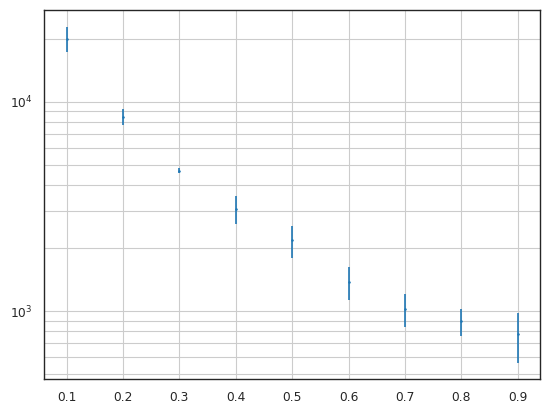

In [140]:
plt.scatter(perfs_with_unc.keys(), [x[0] for x in perfs_with_unc.values()], s=1)
plt.errorbar(perfs_with_unc.keys(), [x[0] for x in perfs_with_unc.values()], yerr=[x[1] for x in perfs_with_unc.values()], linestyle="None")
plt.yscale('log')
plt.grid(which='both')
plt.show()

In [159]:
def measure_parity_split(data, number, pairwise=False):
    if not isinstance(data, torch.Tensor):
        data = torch.tensor(data)
    if not isinstance(number, torch.Tensor):
        number = torch.tensor(number)
    def distance(a, b):
        # Define your distance function here
        return torch.norm(a - b).item()

    odd_position_distances = []
    consecutive_distances = []

    n_elements = len(number)

    if pairwise:
        even = data[number % 2 == 0]
        odd = data[number % 2 == 1]
        even_even = torch.triu(torch.cdist(even, even))
        even_even = even_even[even_even != 0]
        odd_odd = torch.triu(torch.cdist(odd, odd))
        odd_odd = odd_odd[odd_odd != 0]
        even_odd = torch.triu(torch.cdist(even, odd))
        even_odd = even_odd[even_odd != 0]
        return (even_odd.mean() / (even_even.mean() + odd_odd.mean()) * 2).item()

    for i in range(0, n_elements):
        if i+2 < n_elements:
            odd_position_distances.append(distance(data[i], data[i+2]))
        if i+1 < n_elements:
            consecutive_distances.append(distance(data[i], data[i+1]))

    avg_odd_position_distance = sum(odd_position_distances) / len(odd_position_distances)
    avg_consecutive_distance = sum(consecutive_distances) / len(consecutive_distances)

    return (avg_consecutive_distance / avg_odd_position_distance).item()

def measure_orderedness(data):
    assert data.shape[1] == 1
    # fraction of ordered elements (next > prev)
    def descending(a):
        return ((a[::2][1:] > a[::2][:-1]).mean() + (a[1::2][1:] > a[1::2][:-1]).mean()).item()/2
    def ascending(a):
        return ((a[::2][1:] < a[::2][:-1]).mean() + (a[1::2][1:] < a[1::2][:-1]).mean()).item()/2
    return max(descending(data), ascending(data))

In [160]:
seed_of_choice = 1

In [161]:
all_paritys = {} 
for frac, location in all_trainfracs.items():
    paritys = defaultdict(list)
    args = IO.load_args(f"{location}/args.yaml")
    data = prepare_nuclear_data(args)
    mask = mask_elements_used_in_train(data)

    which_nzs_val = data.X[data.val_mask & mask].cpu()
    which_z_val = which_nzs_val[:,0].unique()
    which_n_val = which_nzs_val[:,1].unique()

    which_nzs_full = data.X[mask].cpu()
    which_z_full = which_nzs_full[:,0].unique()
    which_n_full = which_nzs_full[:,1].unique()

    with torch.no_grad():
      for epoch, model_path in checkpoints.items():
        if epoch != last_epoch: continue
        # if frac[0] != seed_of_choice: continue
        model.load_state_dict(torch.load(f"{location}/ckpts/{model_path}", map_location="cpu"))

        z_emb = model.emb[0][which_z_val]
        n_emb = model.emb[1][which_n_val]

        z_emb_full = model.emb[0][which_z_full]
        n_emb_full = model.emb[1][which_n_full]
        # z_emb, n_emb = model.emb[0], model.emb[1]
        # z_emb, n_emb = z_emb[args.NUCLEI_GE + 1:140], n_emb[args.NUCLEI_GE + 1:140]
        
        for name, emb, which in zip(("z", "n", "full_z", "full_n"), (z_emb, n_emb, z_emb_full, n_emb_full), (which_z_val, which_n_val, which_z_full, which_n_full)):
          paritys[name+"_parity"].append(measure_parity_split(emb.cpu().numpy(), which, pairwise=True))
          n_components = 1
          offset = 0
          pca = PCA(n_components=n_components + offset)
          emb_pca = pca.fit_transform(emb.detach().cpu().numpy())
          paritys[name+"_orderedness"].append(measure_orderedness(emb_pca[:,[0]]))
        # for first in range(offset, n_components + offset):
        #   for second in range(first + 1, n_components + offset):
        #     parity = measure_orderedness(emb_pca[:, [0]])
        #     paritys[(first, second)].append(parity)
        #     plt.scatter(emb_pca[:, first], emb_pca[:, second], c=np.arange(len(emb_pca))%2, cmap="coolwarm")
        #     plt.title(f"parity: {measure_orderedness(emb_pca[:, [0]])}, {first} vs {second}, perf {perfs[frac][last_epoch]:.0f}, frac {frac}")
        #     for i, txt in enumerate(np.arange(len(emb_pca))):
        #       plt.annotate(txt, (emb_pca[i, first], emb_pca[i, second]))
        #     plt.show()
    all_paritys[frac] = paritys

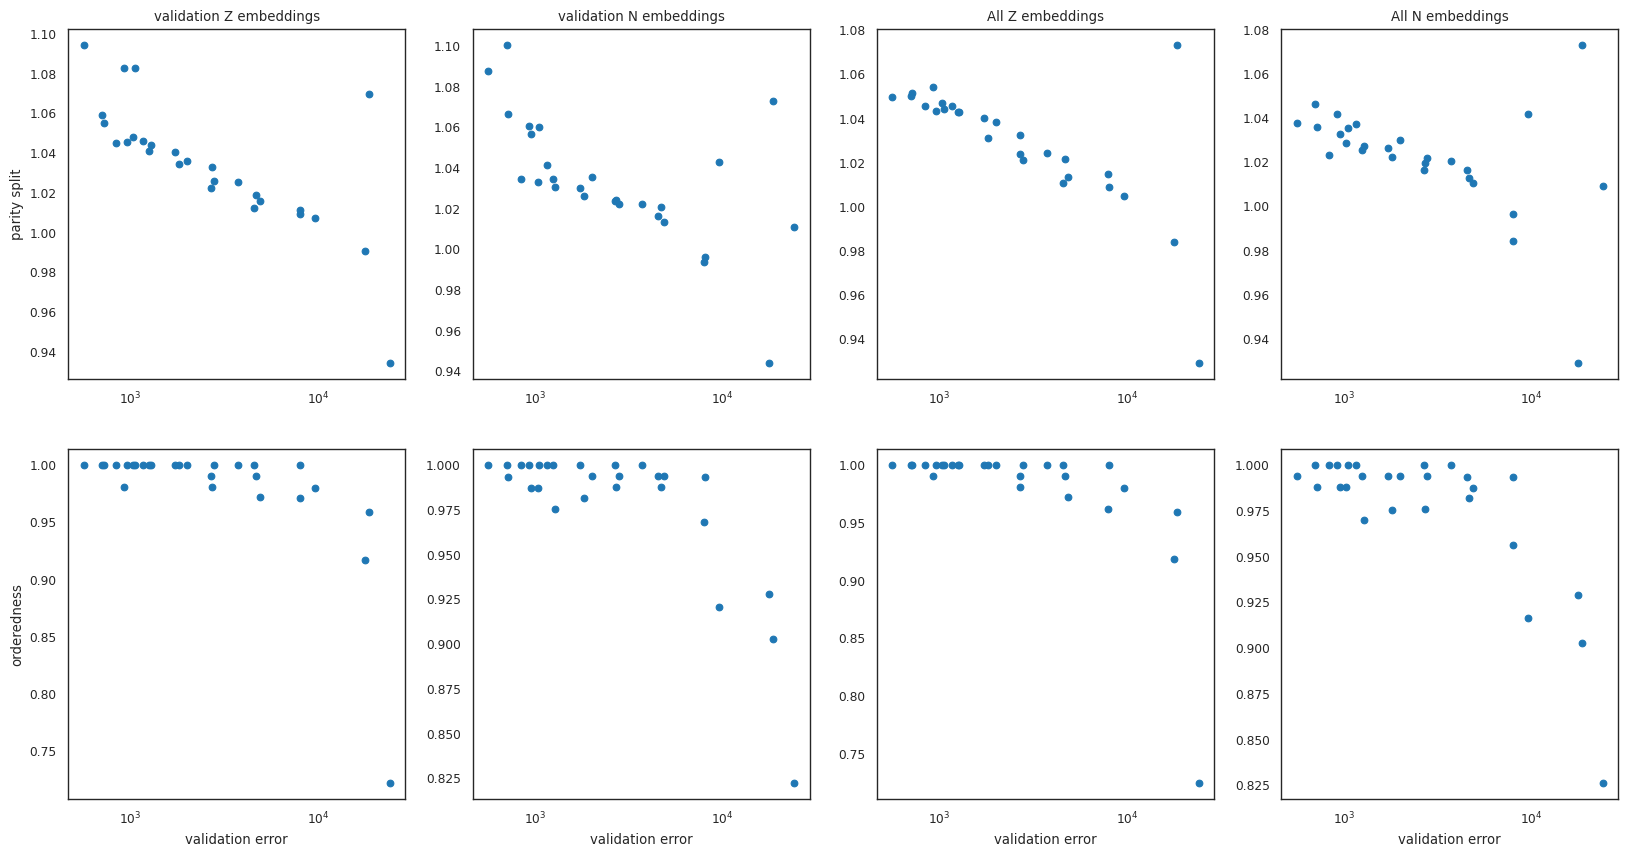

In [184]:
perfs_for_plot = []
paritys_for_plot = defaultdict(list)
for seed in set([x[0] for x in all_paritys.keys()]):
  for frac in set([x[1] for x in all_paritys.keys()]):
    perfs_for_plot.append(perfs[(seed, frac)][last_epoch])
    for name,obs in all_paritys[(seed, frac)].items():
      # if frac < .2: continue
      # if seed != seed_of_choice: continue
      paritys_for_plot[name].append(max(obs))
      # paritys_for_plot.append(max([x[-1] for x in all_paritys[(seed, frac)].values()]))


fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i, (name, obs) in enumerate(paritys_for_plot.items()):
  ax[i%2, i//2].scatter(perfs_for_plot, obs, label=name)
  if i % 2 == 1:
    ax[i%2, i//2].set_xlabel("validation error")
  ax[i%2, i//2].set_xscale('log')
  if "parity" in name:
    # ax[i//2, i//2].set_ylabel("2 x d(even,odd) / (d(even,even) x d(odd,odd))")
    if i//2 == 0:
      ax[i%2, i//2].set_ylabel("parity split")
  elif "orderedness" in name:
    if i//2 == 0:
      ax[i%2, i//2].set_ylabel("orderedness")
  if "full_z" in name:
    if i % 2 == 0:
      ax[i%2, i//2].set_title("All Z embeddings")
  elif "full_n" in name:
    if i % 2 == 0:
      ax[i%2, i//2].set_title("All N embeddings")
  elif "n_" in name:
    if i % 2 == 0:
      ax[i%2, i//2].set_title("validation N embeddings")
  elif "z_" in name:
    if i % 2 == 0:
      ax[i%2, i//2].set_title("validation Z embeddings")
plt.show()


In [158]:
all_paritys

{(0,
  0.1): defaultdict(list,
             {'z_parity': [tensor(0.9342)],
              'z_orderedness': [0.721938775510204],
              'n_parity': [tensor(1.0110)],
              'n_orderedness': [0.8222124670763828],
              'full_z_parity': [tensor(0.9287)],
              'full_z_orderedness': [0.7244897959183674],
              'full_n_parity': [tensor(1.0091)],
              'full_n_orderedness': [0.8260869565217391]}),
 (1,
  0.1): defaultdict(list,
             {'z_parity': [tensor(1.0695)],
              'z_orderedness': [0.9591836734693877],
              'n_parity': [tensor(1.0729)],
              'n_orderedness': [0.9029850746268657],
              'full_z_parity': [tensor(1.0733)],
              'full_z_orderedness': [0.9593877551020409],
              'full_n_parity': [tensor(1.0729)],
              'full_n_orderedness': [0.9029850746268657]}),
 (2,
  0.1): defaultdict(list,
             {'z_parity': [tensor(0.9906)],
              'z_orderedness': [0.9175170068

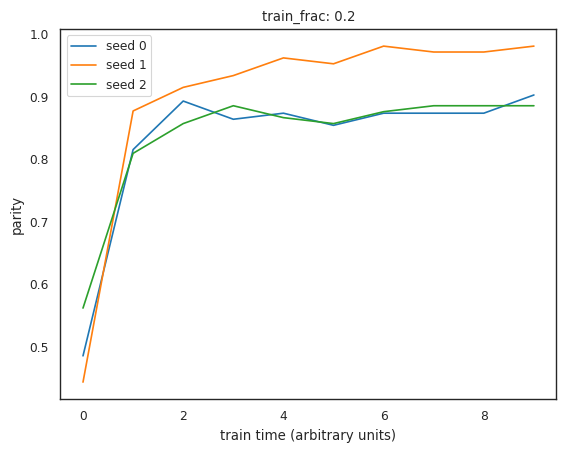

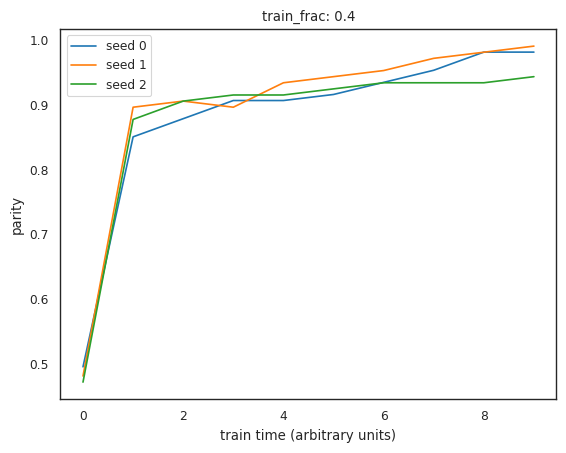

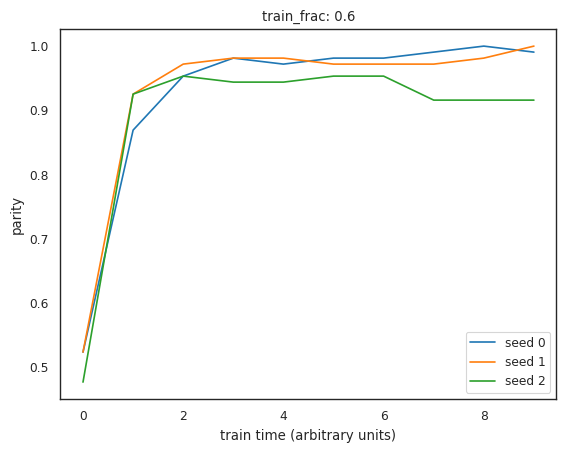

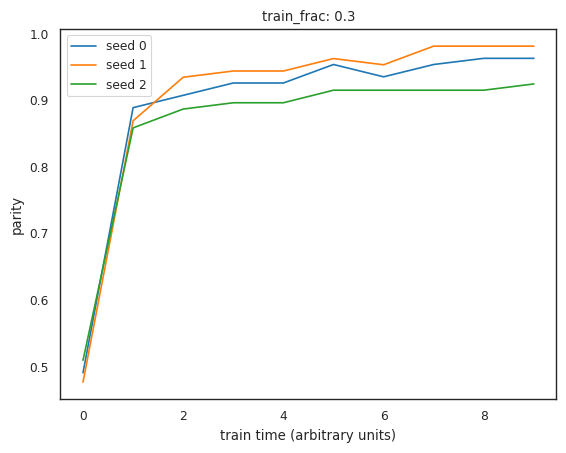

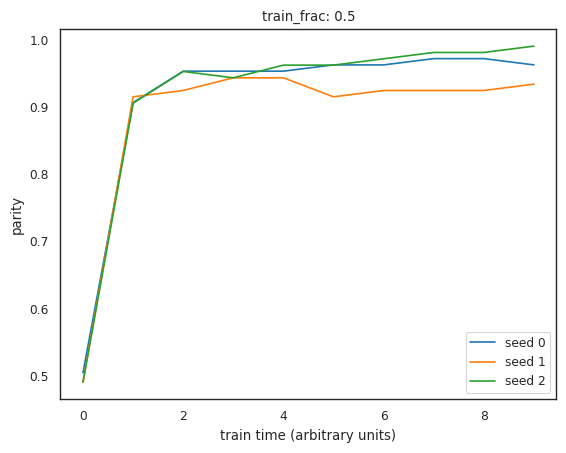

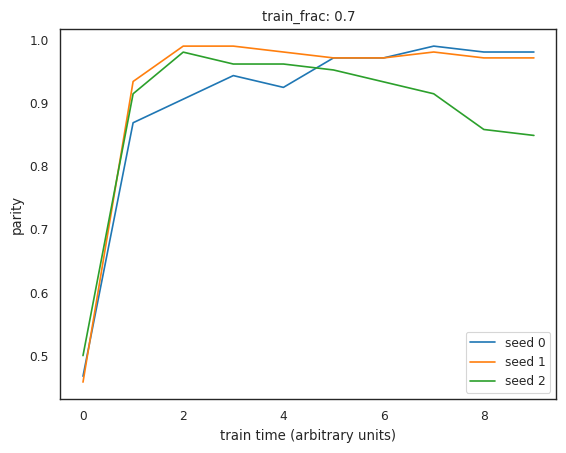

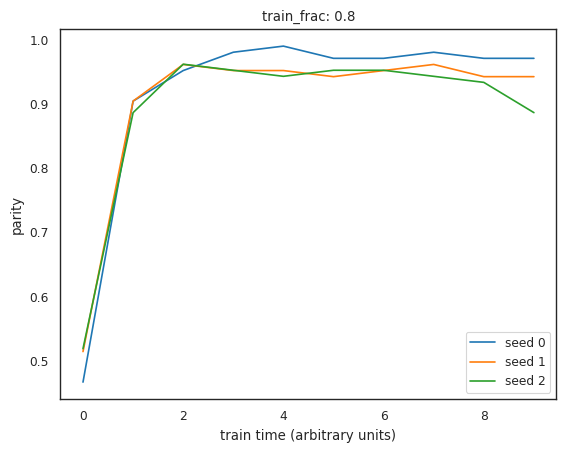

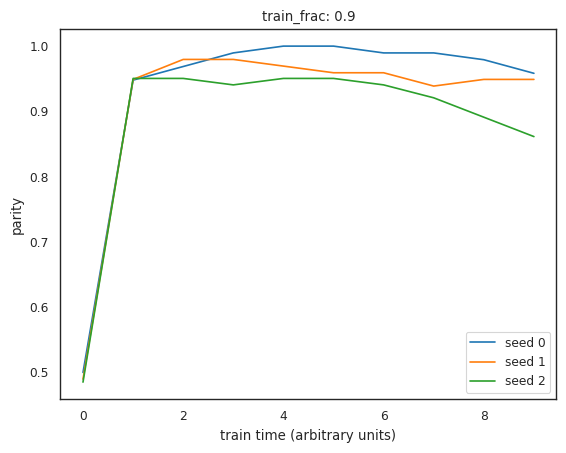

In [74]:
for train_frac in set([x[1] for x in all_paritys.keys()]):
  for seed in set([x[0] for x in all_paritys.keys()]):
    # if seed != seed_of_choice: continue
    # plotting the parity as a function train time for different train fracs
    values = all_paritys[(seed, train_frac)][(0,1)]
    plt.plot(values, label=f"seed {seed}")
  plt.title(f"train_frac: {train_frac}")
  plt.xlabel("train time (arbitrary units)")
  plt.ylabel("parity")
  plt.legend()
  plt.show()